In [1]:
%env MKL_NUM_THREADS=16
%env OMP_NUM_THREADS=16

env: MKL_NUM_THREADS=16
env: OMP_NUM_THREADS=16


In [2]:
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import random_grid, find_optimal_config
from polara.recommender.coldstart.models import ItemColdStartEvaluationMixin
from polara.recommender.external.turi.turiwrapper import (TuriFactorizationRecommender,
                                                          ColdStartRecommendationsMixin)

from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)

%matplotlib inline

In [3]:
seed = 42

In [4]:
experiment_name = 'fm'

# Experiment setup

In [5]:
data_labels = ['ML1M', 'ML10M', 'BX']

In [6]:
# according to https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html
init_config = dict(with_data_feedback = False, # implicit case
                   ranking_optimization = True,
                   solver = 'adagrad',
                   sgd_step_size = 0, # let Turi autotune it
                   seed = seed,
                   max_iterations = 25,
                   other_tc_params = {}
                   )
fm_init_config = dict.fromkeys(data_labels, {'FM': init_config, # standard scenario
                                             'FM(cs)': init_config}) # cold start

In [7]:
params = {
          'regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'linear_regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'rank': [40] # for initial tuning (exploration)
         }

if init_config['solver'] == 'adagrad':
    params.update({
                   'adagrad_momentum_weighting': [0.9, 0.95, 0.99]
                  })      

In [8]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300, 350, 400,
              500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

In [9]:
fm_ranks = {'ML1M': [r for r in ranks_grid if r <= 1000],
             'ML10M': [r for r in ranks_grid if r <= 1000],
             'BX': [r for r in ranks_grid if r <= 2000]}

In [10]:
topk_values = [1, 3, 10, 20, 30]

In [11]:
target_metric = 'mrr'

In [12]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)

In [13]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Movielens1M

In [14]:
lbl = 'ML1M'

In [15]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('/mnt/bulky/datasets/recsys/movielens/ml-1m.zip',
                                                    meta_path='data/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [16]:
# not used actually, simply to onform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

## Movielens10M

In [17]:
lbl = 'ML10M'

In [18]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('/mnt/bulky/datasets/recsys/movielens/ml-10m.zip',
                                                    meta_path='data/meta_info_ml10m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [19]:
# not used actually, simply to onform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

In [20]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## BookCrossing

In [21]:
lbl = 'BX'

In [22]:
data_dict[lbl], meta_dict[lbl] = get_bookcrossing_data('/mnt/bulky/datasets/recsys/bookcrossing/BX-CSV-Dump.zip',
                                                       get_books_meta=True,
                                                       implicit=True,
                                                       pcore=5,
                                                       filter_no_meta=True)

/home/evfro/miniconda3/envs/polara_dev/lib/python3.6/site-packages/pandas/io/parsers.py:1990: DeprecationWarning: invalid escape sequence '\8'
  data = self._reader.read(nrows)
/home/evfro/miniconda3/envs/polara_dev/lib/python3.6/site-packages/pandas/io/parsers.py:1990: DeprecationWarning: invalid escape sequence '\9'
  data = self._reader.read(nrows)


In [23]:
# not used actually, simply to onform with general pipeline
itemid = meta_dict[lbl].index.name
sim_indices[lbl] = {itemid: meta_dict[lbl].index}
similarities[lbl] = {itemid: sp.sparse.eye(len(meta_dict[lbl].index))}

In [24]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [25]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 0.028392958546280524
ML10M
{'userid': 69797, 'movieid': 10258}
density 0.6991397242349022
similarity matrix density 0.009748488984207448
BX
{'userid': 7160, 'isbn': 16273}
density 0.18925598044812894
similarity matrix density 0.0005841769822585451


# Standard experiment

In [26]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    fm = TuriFactorizationRecommender(data_model, item_side_info=meta_dict[data_label])
    fm.method = 'FM'
    models = [fm]
    apply_config(models, config, data_label)
    return models

def fine_tune_fm(model, params, label, ntrials=60, record_time_as=None):
    param_grid, param_names = random_grid(params, n=ntrials)
    best_fm_config, fm_scores = find_optimal_config(model, param_grid, param_names,
                                                    target_metric,
                                                    return_scores=True,
                                                    force_build=True,
                                                    iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_fm_config))}
    model_scores = {model.method: fm_scores}
    try:
        if record_time_as:
            save_training_time(f'{experiment_name}_{record_time_as}', model, fm_scores.index, label)
    finally:
        return model_config, model_scores

## tuning

In [27]:
config = {}
scores = {}
times = {}
data_models = {}

In [28]:
fm_init_config['ML1M']['FM']

{'with_data_feedback': False,
 'ranking_optimization': True,
 'solver': 'adagrad',
 'sgd_step_size': 0,
 'seed': 42,
 'max_iterations': 25,
 'other_tc_params': {}}

In [29]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, fm_init_config)
    config[label], scores[label] = fine_tune_fm(model, params, label, ntrials=60, record_time_as='param')
del model

 [████████████████████████████████████████████████████████████] 3/3 [09:24:40<13:48, 11293.31s/it]

           ML1M [█████████████████████████████████████████████] 60/60 [55:09<00:50, 55.15s/it]

          ML10M [█████████████████████████████████████████████] 60/60 [08:15:35<09:25, 495.58s/it]

             BX [█████████████████████████████████████████████] 60/60 [13:48<00:13, 13.79s/it]

/home/evfro/miniconda3/envs/polara_dev/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


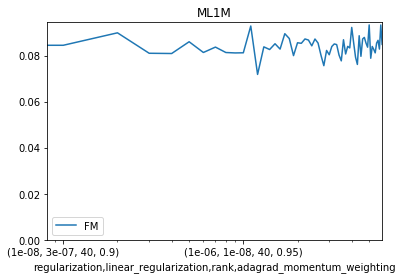

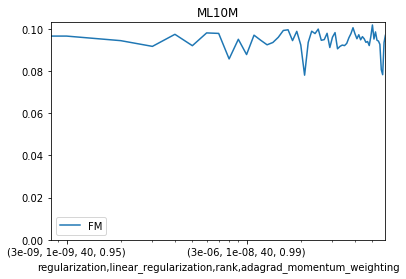

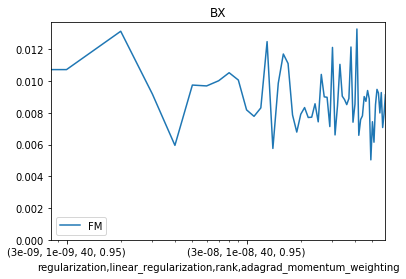

In [30]:
report_results('tuning', scores);

In [31]:
config

{'ML1M': {'FM': {'regularization': 3e-08,
   'linear_regularization': 1e-10,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}},
 'ML10M': {'FM': {'regularization': 1e-06,
   'linear_regularization': 3e-07,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}},
 'BX': {'FM': {'regularization': 1e-06,
   'linear_regularization': 3e-08,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}}}

### saving data

In [32]:
save_results(f'{experiment_name}_param', config=config, tuning=scores)

## rank estimation

In [33]:
rank_config = {}
rank_scores = {}

In [34]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models,
                                        [fm_init_config, config]) # initiate with optimal config
    rank_config[label], rank_scores[label] = fine_tune_fm(model, {'rank': fm_ranks[label]},
                                                          label, ntrials=0, record_time_as='rank')
del model

 [████████████████████████████████████████████████████████████] 3/3 [08:47:04<21:52, 10541.42s/it]

           ML1M [█████████████████████████████████████████████] 20/20 [54:37<00:38, 163.84s/it]

          ML10M [█████████████████████████████████████████████] 20/20 [07:30:36<44:57, 1351.79s/it]

             BX [█████████████████████████████████████████████] 24/24 [21:51<00:40, 54.65s/it]

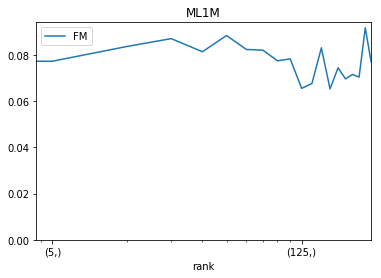

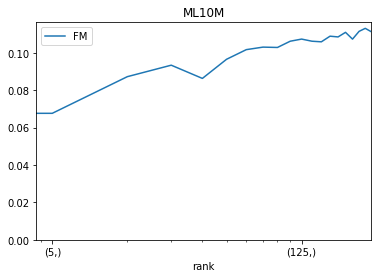

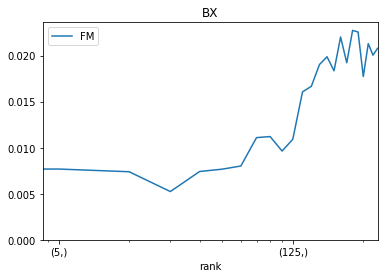

In [35]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores.items() for k, v in scr.items()});

In [36]:
rank_config

{'ML1M': {'FM': {'rank': 750}},
 'ML10M': {'FM': {'rank': 750}},
 'BX': {'FM': {'rank': 750}}}

### saving data

In [37]:
save_results(f'{experiment_name}_rank', config=rank_config, tuning=rank_scores)

## cross-validation

In [38]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, [fm_init_config, config, rank_config])
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 3/3 [05:52:21<11:55, 7047.02s/it]

           ML1M [█████████████████████████████████████████████] 5/5 [33:45<06:50, 404.94s/it]

          ML10M [█████████████████████████████████████████████] 5/5 [05:06:41<01:01:12, 3680.21s/it]

             BX [█████████████████████████████████████████████] 5/5 [11:55<01:45, 143.05s/it]

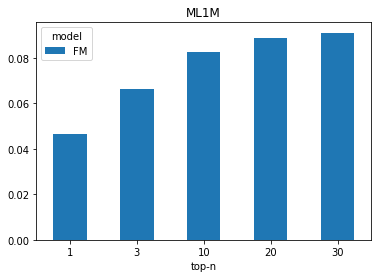

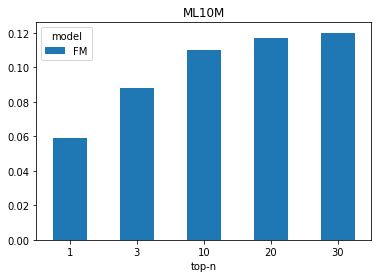

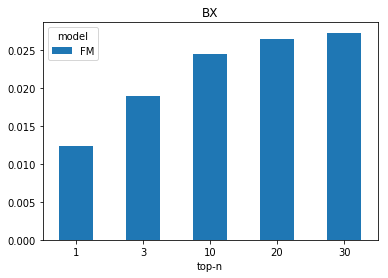

In [39]:
report_results('topn', result, target_metric);

In [40]:
pd.concat({lbl: res.mean(level='top-n').loc[10, :'ranking'] for lbl, res in result.items()}, axis=1)

,,BX,ML10M,ML1M
type,metric,,,
relevance,hr,0.061034,0.257876,0.190189
ranking,mrr,0.024515,0.109986,0.082559


### saving data

In [41]:
save_results(experiment_name, cv=result)

# Cold start

In [42]:
class TuriRecommenderColdStart(ItemColdStartEvaluationMixin,
                               ColdStartRecommendationsMixin,
                               TuriFactorizationRecommender): pass

def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    fm = TuriRecommenderColdStart(data_model, item_side_info=meta_dict[data_label])
    fm.method = 'FM(cs)'
    models = [fm]
    apply_config(models, config, data_label)
    return models

## tuning

In [43]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [45]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model, =  prepare_cold_start_recommender_models(label, data_models_cold, fm_init_config)
    config_cold[label], scores_cold[label] = fine_tune_fm(model, params, label, ntrials=60)
del model

 [████████████████████████████████████████████████████████████] 3/3 [13:44:00<55:24, 16480.13s/it]

           ML1M [█████████████████████████████████████████████] 60/60 [56:30<00:55, 56.51s/it]

          ML10M [█████████████████████████████████████████████] 60/60 [11:52:03<11:58, 712.04s/it]

             BX [█████████████████████████████████████████████] 60/60 [55:23<00:53, 55.39s/it]

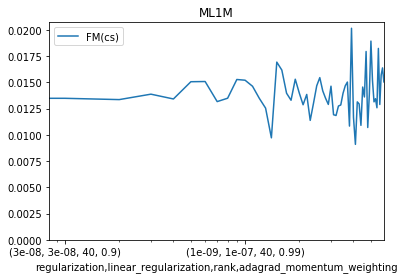

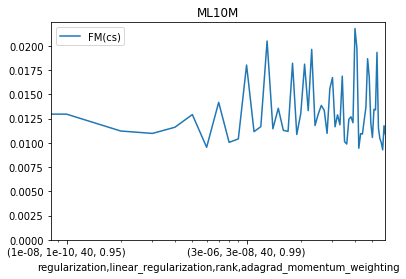

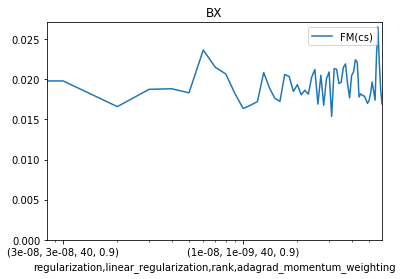

In [46]:
report_results('tuning', scores_cold);

In [47]:
config_cold

{'ML1M': {'FM(cs)': {'regularization': 1e-10,
   'linear_regularization': 1e-06,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}},
 'ML10M': {'FM(cs)': {'regularization': 3e-06,
   'linear_regularization': 1e-06,
   'rank': 40,
   'adagrad_momentum_weighting': 0.95}},
 'BX': {'FM(cs)': {'regularization': 3e-06,
   'linear_regularization': 3e-07,
   'rank': 40,
   'adagrad_momentum_weighting': 0.95}}}

### saving data

In [48]:
save_results(f'{experiment_name}_coldstart_param', config=config_cold, tuning=scores_cold)

## rank estimation

In [ ]:
rank_config_cold = {}
rank_scores_cold = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_cold_start_recommender_models(label, data_models_cold,
                                                   [fm_init_config, config_cold]) # initiate with optimal config
    rank_config_cold[label], rank_scores_cold[label] = fine_tune_fm(model, {'rank': fm_ranks[label]},
                                                                    label, ntrials=0)
del model

 [████████████████████████████████████████████████████████████] 3/3 [10:16:25<43:13, 12328.43s/it]

           ML1M [█████████████████████████████████████████████] 20/20 [47:00<00:45, 141.01s/it]

          ML10M [█████████████████████████████████████████████] 20/20 [08:46:12<11:03, 1578.59s/it]

             BX [█████████████████████████████████████████████] 24/24 [43:13<01:20, 108.05s/it]

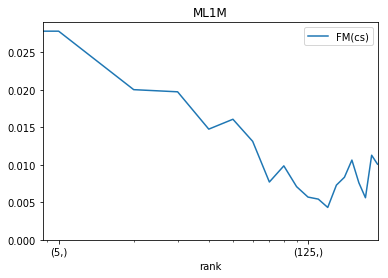

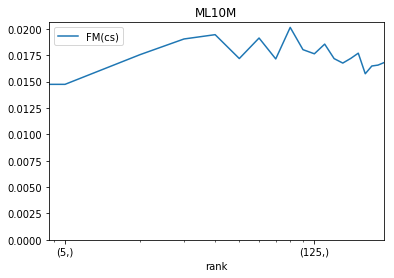

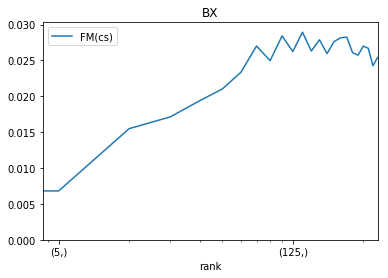

In [ ]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores_cold.items() for k, v in scr.items()});

In [ ]:
rank_config_cold

{'ML1M': {'FM(cs)': {'rank': 5}},
 'ML10M': {'FM(cs)': {'rank': 75}},
 'BX': {'FM(cs)': {'rank': 150}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart_rank', config=rank_config_cold, tuning=rank_scores_cold)

## cross validation

In [ ]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold,
                                                        [fm_init_config, config_cold, rank_config_cold])
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=label))

 [████████████████████########################################] 1/3 [02:37<02:37, 156.74s/it]

           ML1M [█████████████████████████████████████████████] 5/5 [02:37<00:31, 31.35s/it]

          ML10M [#############################################] 0/5 [0<0, 0.00s/it]

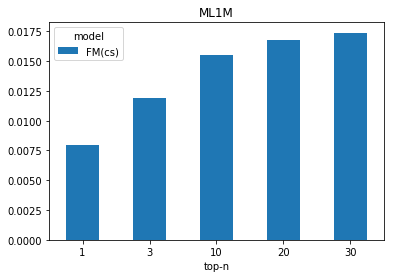

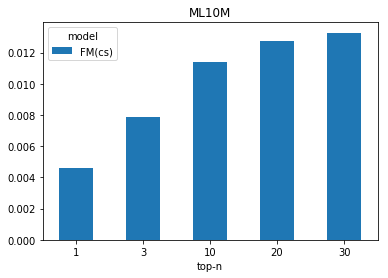

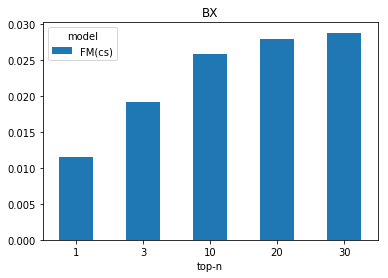

In [60]:
report_results('topn', result_cold, target_metric);

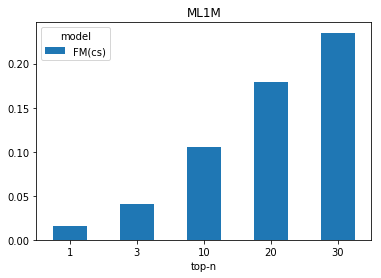

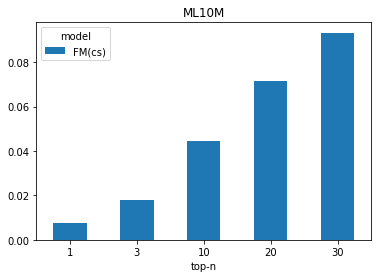

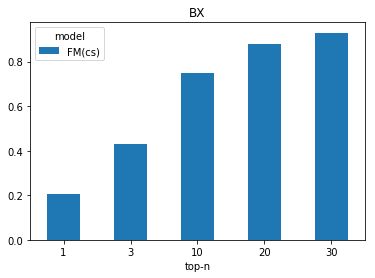

In [61]:
report_results('topn', result_cold, 'coverage');

### saving data

In [ ]:
save_results(f'{experiment_name}_coldstart', cv=result_cold)